Hatırlatma: 
- toPandas ve collect fonksiyonlarını veriyi localimize çekmek için kullanabiliriz.   
- Önce Spark oturumu açıp sonra bağlamı kuruyor/başlatıyoruz.

In [1]:
!pip install findspark

In [2]:
import findspark
findspark.init("c:\spark")

In [6]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

In [9]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("churn_modelling") \
                    .getOrCreate()

In [13]:
sc = spark.sparkContext
sc

<SparkContext master=local appName=churn_modelling>

In [15]:
spark_df = spark.read.csv("churn.csv", header = True, inferSchema = True, sep = ",")

In [16]:
spark_df.show(5)

+---+----------------+----+--------------+---------------+-----+---------+-----+
|_c0|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+---+----------------+----+--------------+---------------+-----+---------+-----+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|  3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|
|  4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|
+---+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 5 rows



In [18]:
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])

## Keşifçi Veri Analizi 

In [19]:
spark_df.describe().show()

+-------+------------------+-------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|summary|               _c0|        names|              age|   total_purchase|   account_manager|            years|         num_sites|              churn|
+-------+------------------+-------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|  count|               900|          900|              900|              900|               900|              900|               900|                900|
|   mean|             449.5|         null|41.81666666666667|10062.82403333334|0.4811111111111111| 5.27315555555555| 8.587777777777777|0.16666666666666666|
| stddev|259.95191863111916|         null|6.127560416916251|2408.644531858096|0.4999208935073339|1.274449013194616|1.7648355920350969| 0.3728852122772358|
|    min|                 0|   Aaron King|             22.0|          

In [22]:
spark_df.select("age","total_purchase","account_manager","years","num_sites","churn").describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,900,41.81666666666667,6.127560416916251,22.0,65.0
total_purchase,900,10062.82403333334,2408.644531858096,100.0,18026.01
account_manager,900,0.4811111111111111,0.4999208935073339,0,1
years,900,5.27315555555555,1.274449013194616,1.0,9.15
num_sites,900,8.587777777777777,1.7648355920350969,3.0,14.0
churn,900,0.16666666666666666,0.3728852122772358,0,1


Outcome değişkenimize bakınca ortalamasının 0'a yakın olduğunu görüyoruz. Buradan şu sonucuda çıkarabilirsin: Veri seti dağılımı dengeli değil. Özellike Outcome değişkeninin dağılımı istenildiği gibi olmadığında hassas davranmamız gerekiyor. train_test_split önemli hale geliyor

In [32]:
# 45 yaşından büyükleri çekelim ve büyükten küçüğ sıralayalım
spark_df.where(spark_df.age >45).sort("age",ascending=False).show()

+---+------------------+----+--------------+---------------+-----+---------+-----+
|_c0|             names| age|total_purchase|account_manager|years|num_sites|churn|
+---+------------------+----+--------------+---------------+-----+---------+-----+
|247|     Megan Jenkins|65.0|       10430.5|              0|  6.5|      6.0|    0|
|596|         Wendy Key|60.0|       9621.04|              1| 7.65|      8.0|    0|
| 63|   Carla Patterson|58.0|      12376.37|              0| 6.01|     12.0|    1|
|147|      Robert Russo|58.0|       9703.93|              0| 5.16|     11.0|    1|
|367|      Johnny Watts|56.0|       8626.48|              1| 5.07|      7.0|    0|
|175|     William Haney|56.0|      12502.81|              0| 5.47|      8.0|    0|
|302| Jeffrey Hernandez|56.0|       9940.54|              1| 6.57|      7.0|    0|
|500|Johnathan Gonzalez|56.0|       10074.4|              1| 5.17|      7.0|    0|
| 21|       Kevin Ramos|56.0|      12217.95|              1| 5.79|     11.0|    1|
| 24

In [33]:
## 45 yaşından küçükleri çekelim ve küçükten büyüğe sıralayalım
spark_df.where(spark_df.age < 45).sort("age",ascending=True).show()

+---+------------------+----+--------------+---------------+-----+---------+-----+
|_c0|             names| age|total_purchase|account_manager|years|num_sites|churn|
+---+------------------+----+--------------+---------------+-----+---------+-----+
|807|Katherine Sandoval|22.0|      11254.38|              1| 4.96|      8.0|    0|
|653|        Gail Lopez|25.0|       9672.03|              0| 5.49|      8.0|    0|
|118|     Hunter Rivera|26.0|       8787.39|              1| 5.42|     11.0|    1|
|843|    Anthony Molina|26.0|       8939.61|              0| 4.54|      7.0|    0|
|670|      Trevor Burns|27.0|        8628.8|              1|  5.3|      7.0|    0|
|478|    Kylie Reynolds|28.0|       9090.43|              1| 5.74|     10.0|    0|
|874|        Scott Love|28.0|      11128.95|              1| 5.12|      8.0|    0|
|728|  Caitlin Johnston|28.0|      11245.38|              0| 6.72|      8.0|    0|
|834|   William Pearson|28.0|      11204.23|              0| 3.67|     11.0|    0|
|822

In [40]:
spark_df.filter(spark_df.age < 45).count()

606

In [38]:
## yaş sınıfların sayısına bakalım
spark_df.groupby("age").count().select("age","count").show()

+----+-----+
| age|count|
+----+-----+
|49.0|   30|
|29.0|    9|
|47.0|   29|
|42.0|   49|
|44.0|   53|
|35.0|   32|
|39.0|   48|
|37.0|   48|
|34.0|   25|
|25.0|    1|
|36.0|   39|
|41.0|   69|
|56.0|    5|
|50.0|   15|
|45.0|   56|
|31.0|   11|
|58.0|    2|
|51.0|   21|
|48.0|   36|
|22.0|    1|
+----+-----+
only showing top 20 rows



Yukarıdaki gibi çaprazlama işlemleri ile veri setini önce tanımamız gerekiyor. !!!!! Unutma, makine öğrenmsi bir fonksiyon ile çözülebilir fakat işin geri kalanı yorumlama ve anlam çıkarma. Yani sadece Makine Öğrenmesi var diye bu alana gelmek gerçekten büyük bir aptallık!

In [42]:
spark_df.where(spark_df.age < 50 && spark_df.years>1)

SyntaxError: invalid syntax (747992115.py, line 1)

In [44]:
spark_df.where(spark_df.age < 50).count()

805

In [46]:
## & bağlacı yoksa, kendi yolumuzu çizeriz yeğen
spark_df.where(spark_df.age < 50).where(spark_df.years > 1).count()


804

In [50]:
## yaşı 45'ten küçük olup en az 2 senelik müşteri olanlar için kampanya yapacaz diyelim
spark_df.where(spark_df.age < 45).where(spark_df.years >= 2) .count()

600

In [57]:
## 45 ve 40 arasında olup bizi bırakanları bulalım be...
print("40-45 arası bize sorun sende değil bende diyenlerin sayısı: ", spark_df.where(spark_df.age < 45 ).where(spark_df.age > 40).where(spark_df.churn ==1).count())
spark_df.where(spark_df.age < 45 ).where(spark_df.age > 40).where(spark_df.churn ==1).sort("age",ascending=True).show()

40-45 arası bize sorun sende değil bende diyenlerin sayısı:  39
+---+----------------+----+--------------+---------------+-----+---------+-----+
|_c0|           names| age|total_purchase|account_manager|years|num_sites|churn|
+---+----------------+----+--------------+---------------+-----+---------+-----+
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
| 40|    Patrick Bell|41.0|      11699.26|              0| 6.99|     12.0|    1|
| 20|     Dean Miller|41.0|       9771.22|              0| 5.81|     11.0|    1|
| 14|  Harold Griffin|41.0|       6569.87|              1|  4.3|     11.0|    1|
| 94| Dakota Williams|41.0|       13190.3|              1| 7.38|     10.0|    1|
|117|   April Freeman|41.0|       9923.79|              1| 4.75|     13.0|    1|
|144|  Hailey Sanchez|41.0|      14429.41|              1| 5.51|     11.0|    1|
|149|    Yvette Perry|41.0|       8560.76|              1| 3.99|     12.0|    1|
| 52|   Laura Fleming|41.0|      10179.92|   

In [59]:
## birde bağımsız değişkene bakalım ne durumda deiye
spark_df.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



Yaniiiii. Çokta düzgün değil. Bunu ileride ele alacağız.

In [63]:
## bizi bırakan-bırakmayanların ortalama harcamalarına bakalım.
spark_df.groupby("churn").agg({"total_purchase" : "mean"}).show()

+-----+-------------------+
|churn|avg(total_purchase)|
+-----+-------------------+
|    1| 10192.179933333337|
|    0| 10036.952853333332|
+-----+-------------------+



Bizi bırakan-bırakmayanların harcamaları çokta farklı değil. Buradan şu sonucu çıkarabiliriz, demekki bizim müşerilerimizin harcama durumu onalrın bizi bırakmasında biretken değilmiş. Sektörel ifadeyle kullanırsak "churn etmesinde etken değilmiş".

In [65]:
spark_df.groupby("churn").agg({"years":"mean"}).show()

+-----+------------------+
|churn|        avg(years)|
+-----+------------------+
|    1|5.8835999999999995|
|    0|5.1510666666666625|
+-----+------------------+



Müşterimiz olduğu yıllarda ortak. Demekki bu da tek başına bir etken değil. Peki ben çaprazlama yapıp birden fazla değişkeni işin içerisine katsam ve sonuçlaı öyle değerlendirsem? Tabii ki bir Veri Bİlimci bunu yapar.

Bir korelasyon matrisi oluşturup inceleyelim

In [70]:
corr_data = spark_df.drop("names","_c0","churn").toPandas()

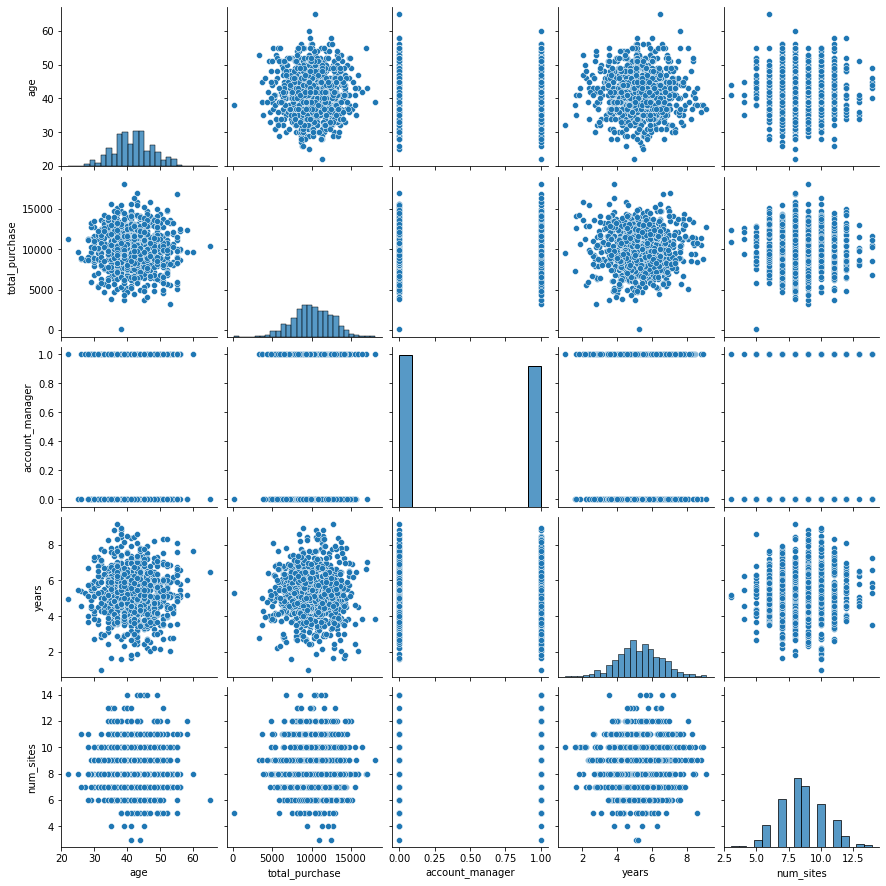

In [71]:
import seaborn as sns
sns.pairplot(corr_data);

Churnu bir kırılım olarak ekleyip bakalım birde 

In [72]:
corr_data = spark_df.drop("names","_c0").toPandas()

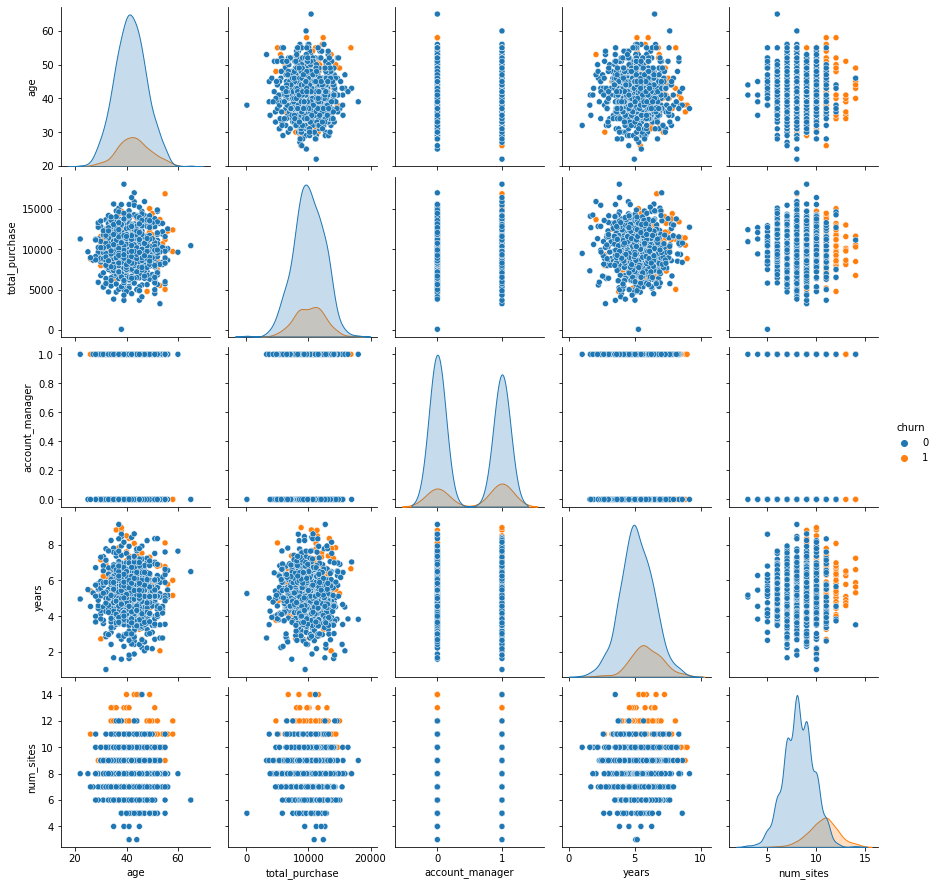

In [73]:
sns.pairplot(corr_data, hue = "churn")

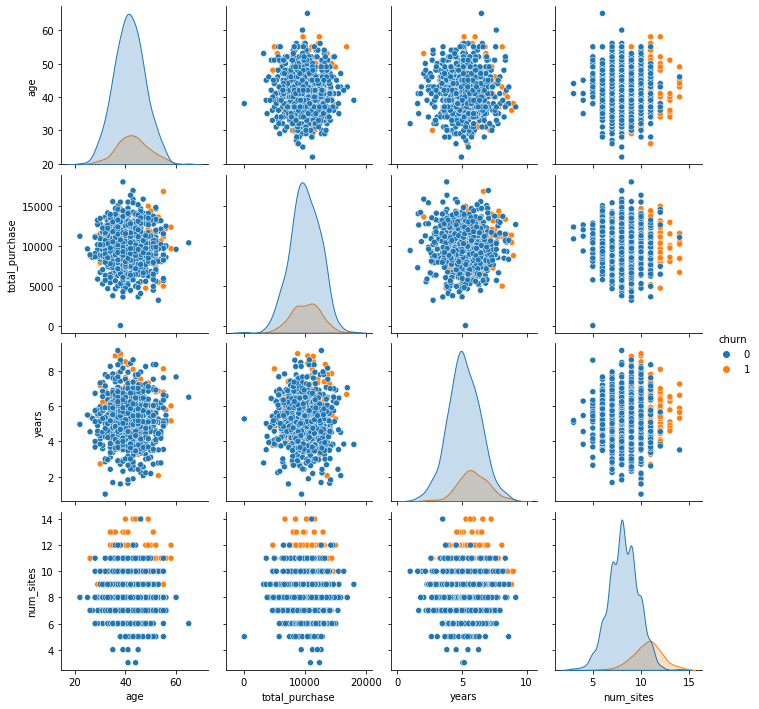

In [74]:
sns.pairplot(corr_data, hue="churn", vars = ["age","total_purchase","years","num_sites"])

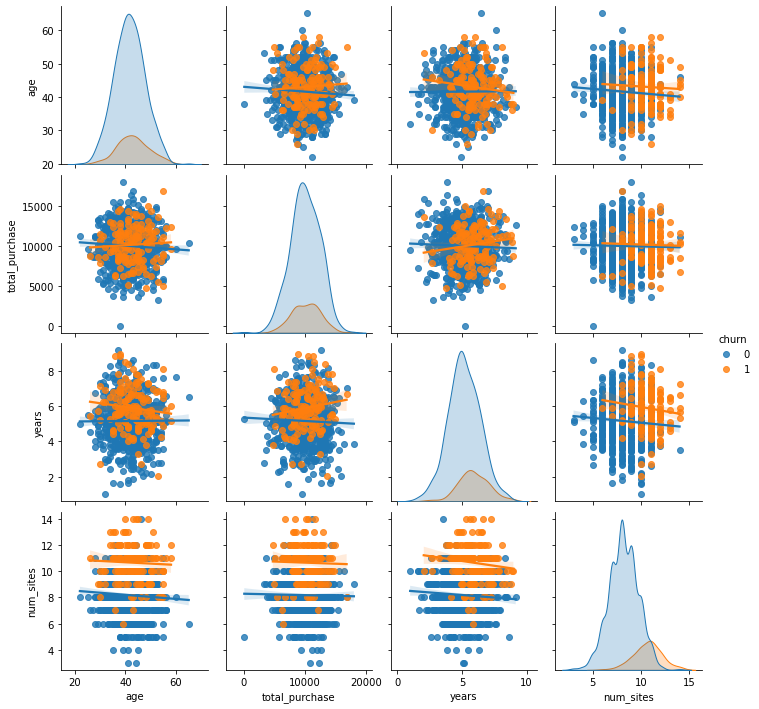

In [76]:
sns.pairplot(corr_data, hue="churn", vars = ["age","total_purchase","years","num_sites"], kind = "reg")  ## ayrışmalar çok daha belli